In [3]:
from pathlib import Path
import os

try:
    import wandb
except:
    if os.environ['COLAB_RELEASE_TAG']:
        print("Found Colab Environment")
        from google.colab import drive
        drive.mount('/content/drive')
        from google.colab import auth
        auth.authenticate_user()

        %pip install -q tensorflow==2.10.0 wandb python-dotenv tensorboard_plugin_profile tensorflow_io==0.27.0
        exit()
    elif Path().cwd().name == 'Mushroom-Classifier':
        print("Found Other Environment")
        %pip install -q tensorflow==2.10.0 wandb python-dotenv tensorboard_plugin_profile tensorflow_io==0.27.0
        exit()
    else:
        print('Please run this notebook from the root of the repository')
        exit()

%cd /content/drive/MyDrive/Mushroom-Classifier

[Errno 2] No such file or directory: '/content/drive/MyDrive/Mushroom-Classifier'
/home/broug/Desktop/Mushroom-Classifier/training


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import math, re, os, pickle
import tensorflow as tf
from datetime import datetime
import wandb
from wandb.keras import WandbCallback, WandbModelCheckpoint
import numpy as np
from matplotlib import pyplot as plt
# from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from src.models.swintransformer import SwinTransformer
from src.training.NN import create_model
# from src.optimizers import lion
# from prefect import task, flow

print(f"Tensorflow version {tf.__version__}")
AUTO = tf.data.experimental.AUTOTUNE
np.set_printoptions(threshold=15, linewidth=80)

from train_config import GCFG, CFG

2023-11-12 13:09:51.653571: I tensorflow/compiler/xla/stream_executor/tpu/tpu_initializer_helper.cc:242] Libtpu path is: libtpu.so
D1112 13:09:51.762660973   83890 config.cc:175]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1112 13:09:51.762681117   83890 config.cc:175]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1112 13:09:51.762685646   83890 config.cc:175]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1112 13:09:51.762689146   83890 config.cc:175]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1112 13:09:51.762693623   83890 config.cc:175]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1112 13:09:51.762697499   83890 config.cc:175]                        gRPC EXPERIMENT event_engine_client                 OFF (default:OFF)
D1112 13:09:51.76270166

Tensorflow version 2.14.0


In [2]:
CFG2 = GCFG()

In [3]:
save_time = datetime.now().strftime('%m%d-%H%M')
log_dir = f"{CFG2.GCS_REPO}/logs/{CFG2.MODEL}/{save_time}"

# wandb.tensorboard.patch(root_logdir=log_dir + "/tf")
wandb.init(project="Mushroom-Classifier", tags=[CFG2.MODEL, CFG2.OPT, CFG2.LR_SCHED, str(CFG2.IMAGE_SIZE[0])])

13:09:58.590 | ERROR   | wandb.jupyter - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.

wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


13:10:03.325 | INFO    | tensorflow - Deallocate tpu buffers before initializing tpu system.

INFO:tensorflow:Initializing the TPU system: local


13:10:03.587 | INFO    | tensorflow - Initializing the TPU system: local

2023-11-12 13:10:06.254489: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562d08341a90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2023-11-12 13:10:06.254526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2023-11-12 13:10:06.254538: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2023-11-12 13:10:06.254548: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2023-11-12 13:10:06.254558: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2023-11-12 13:10:06.254568: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2023-11-12 13:10:06.254578: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2023-11-12 13:10:06.254588: I tensorflow/compiler/xla/service/service.cc:176]   StreamEx

INFO:tensorflow:Finished initializing TPU system.


13:10:10.591 | INFO    | tensorflow - Finished initializing TPU system.

INFO:tensorflow:Found TPU system:


13:10:10.600 | INFO    | tensorflow - Found TPU system:

INFO:tensorflow:*** Num TPU Cores: 8


13:10:10.604 | INFO    | tensorflow - *** Num TPU Cores: 8

INFO:tensorflow:*** Num TPU Workers: 1


13:10:10.608 | INFO    | tensorflow - *** Num TPU Workers: 1

INFO:tensorflow:*** Num TPU Cores Per Worker: 8


13:10:10.611 | INFO    | tensorflow - *** Num TPU Cores Per Worker: 8

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


13:10:10.614 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


13:10:10.618 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


13:10:10.621 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


13:10:10.625 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


13:10:10.628 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


13:10:10.631 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


13:10:10.635 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


13:10:10.638 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


13:10:10.641 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)

INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


13:10:10.645 | INFO    | tensorflow - *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)

Number of accelerators:  8


In [5]:
CFG2.REPLICAS = strategy.num_replicas_in_sync

## Visualization Utils

In [6]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return class_dict[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(class_dict[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                class_dict[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else class_dict[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(class_dict)))
    ax.set_xticklabels(class_dict, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(class_dict)))
    ax.set_yticklabels(class_dict, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if titlestring != "":
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(f'model {title}')
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    wandb.log({"chart": plt})
    path = CFG.ROOT / "images" / CFG.MODEL
    path.mkdir(exist_ok=True)
    plt.savefig(path / f'{title}-{save_time}.png')

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)  # image format uint8 [0,255]
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*CFG.IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "dataset": tf.io.FixedLenFeature([], tf.int64),
        "longitude": tf.io.FixedLenFeature([], tf.float32),
        "latitude": tf.io.FixedLenFeature([], tf.float32),
        "norm_date": tf.io.FixedLenFeature([], tf.float32),
        "class_priors": tf.io.FixedLenFeature([], tf.float32),
        "class_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    label = tf.cast(example['class_id'], tf.int32)
    return image, label


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.cache()
    dataset = dataset.shuffle(CFG.BATCH_SIZE * 10)
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO) # if labeled else read_unlabeled_tfrecord
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    # image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_crop(image, [CFG.MODEL_SIZE, CFG.MODEL_SIZE, 3])
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
     # the training dataset must repeat for several epochs
    dataset = dataset.batch(CFG.BATCH_SIZE)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(CFG.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [8]:
GCS_PATH_SELECT = {
    192: f'{CFG2.GCS_REPO}/tfrecords-jpeg-192x192',
    224: f'gs://{CFG2.GCS_REPO}/tfrecords-jpeg-224x224v2',
    256: f'gs://{CFG2.GCS_REPO}/tfrecords-jpeg-256x256',
    384: f'{CFG2.GCS_REPO}/tfrecords-jpeg-384x384',
    512: f'{CFG2.GCS_REPO}/tfrecords-jpeg-512x512',
}
GCS_PATH = GCS_PATH_SELECT[CFG2.IMAGE_SIZE[0]]
TRAINING_FILENAMES = tf.io.gfile.glob(f'{GCS_PATH}/train*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(f'{GCS_PATH}/val*.tfrec')

class_dict = pickle.load(open(CFG.TRAIN / 'class_dict.pkl', 'rb'))

CFG2.NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
CFG2.NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

CFG = CFG(REPLICAS=CFG2.REPLICAS, NUM_TRAINING_IMAGES=CFG2.NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES=CFG2.NUM_VALIDATION_IMAGES)

In [9]:
CFG

CFG(SEED=32, VERBOSE=2, REPLICAS=8, SAVE_TIME='1112-1309', DEBUG=False, FOLDS=5, DISPLAY_PLOT=True, MODEL='swin_large_224', MODEL_SIZE=224, OPT='Adam', LR_SCHED='CosineWarmup', WGTS=0.2, ES_PATIENCE=5, ROOT=PosixPath('/home/broug/Mushroom-Classifier'), DATA=PosixPath('/home/broug/Mushroom-Classifier/training/data'), TRAIN=PosixPath('/home/broug/Mushroom-Classifier/training'), RAW_DATA=PosixPath('/home/broug/Mushroom-Classifier/training/data/raw'), GCS_REPO='mush-img-repo', GCS_BASE_MODELS='base_models', LOG_FILE=PosixPath('/home/broug/Mushroom-Classifier/logs/1112-1309.log'), CKPT_DIR=PosixPath('/home/broug/models/swin_large_224/1112-1309'), NUM_TRAINING_RECORDS=50, NUM_VALIDATION_RECORDS=2, IMAGE_SIZE=[224, 224], AUGMENT=True, TTA=11, EPOCHS=30, BASE_BATCH_SIZE=32, BATCH_SIZE=256, NUM_TRAINING_IMAGES=96912, NUM_VALIDATION_IMAGES=4373, STEPS_PER_EPOCH=47.0, VALIDATION_STEPS=2.0, LR_START=1e-05, ALPHA=5e-05, WARMUP_TARGET=0.001)

In [26]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

Training data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)


2023-11-12 11:31:16.189515: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Training data label examples: [345 194 218 ... 159 322 424]
Validation data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Validation data label examples: [154 426 118 ... 138 261 270]


2023-11-12 11:31:18.975411: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

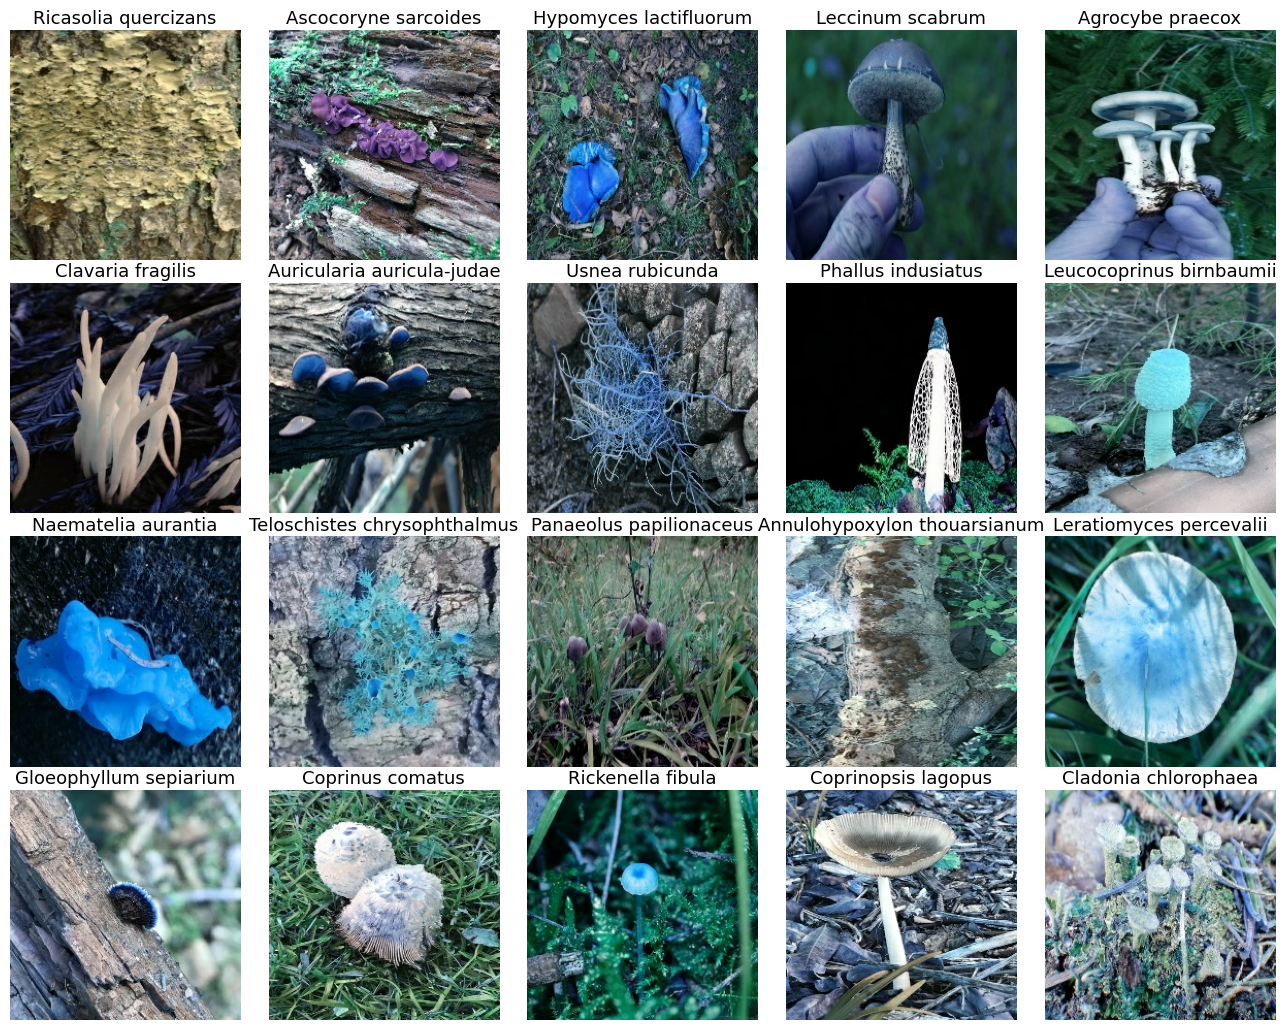

In [29]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

you can select from these models:
- swin_tiny_224
- swin_small_224
- swin_base_224
- swin_base_384
- swin_large_224
- swin_large_384

In [10]:
def make_callbacks(CFG):
    # options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    options = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=CFG.ES_PATIENCE,
            verbose=1,
            restore_best_weights=True,
        ),
        # tf.keras.callbacks.TensorBoard(log_dir=log_dir + "/tf", profile_batch=(50, 250)),
        # tf.keras.callbacks.CSVLogger(
        #     filename=f'gs://{CFG.GCS_REPO}/logs/{save_time}-csv_log.csv',
        #     separator=",",
        #     append=False,
        # ),
        wandb.keras.WandbMetricsLogger(log_freq='batch'),
        # wandb.keras.WandbModelCheckpoint(
        #     str(CFG.ROOT / 'models' / CFG.MODEL / f"{save_time}.h5"),
        #     monitor='val_loss', verbose=1, save_best_only=True,
        #     save_weights_only=True, options=options,
        # )
    ]
    return callbacks

In [11]:
%load_ext tensorboard

In [12]:
with strategy.scope():
    img_adjust_layer = tf.keras.layers.Lambda(
        lambda data: tf.keras.applications.imagenet_utils.preprocess_input(
            tf.cast(data, tf.float32), mode="torch"),
        input_shape=[*CFG.IMAGE_SIZE, 3])
    pt = SwinTransformer(CFG.MODEL, num_classes=len(class_dict), include_top=False, pretrained=False)
    pt.load_weights(f"gs://{CFG.GCS_REPO}/models/checkpoints/{CFG.MODEL}/{CFG.MODEL}.ckpt")

    model = tf.keras.Sequential([
        img_adjust_layer,
        pt,
        tf.keras.layers.Dense(len(class_dict), activation='softmax')
    ])

    top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(
        k=3, name='sparse_top_3_categorical_accuracy'
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=CFG.LR_START, warmup_target=CFG.WARMUP_TARGET,
        warmup_steps=CFG.STEPS_PER_EPOCH, decay_steps=CFG.STEPS_PER_EPOCH * (CFG.EPOCHS - 1)
    )
    optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)
    # model = create_model.fn(CFG, class_dict)

2023-11-12 13:10:34.247467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-12 13:10:34.296752: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-12 13:10:35.799623: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 13:10:35.799686: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


In [13]:
model.compile(
    optimizer=optimizer,  # lion.Lion(learning_rate=lr_decayed_fn),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy', top3_acc],
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 swin_large_224 (SwinTransf  (None, 1536)              195331616 
 ormerModel)                                                     
                                                                 
 dense (Dense)               (None, 467)               717779    
                                                                 
Total params: 196049395 (749.15 MB)
Trainable params: 195713255 (746.59 MB)
Non-trainable params: 336140 (2.56 MB)
_____

In [17]:
service_addr = cluster_resolver.get_master().replace(':8470', ':8466')

print(service_addr)
# %tensorboard --logdir=gs://mush-img-repo/logs

In [14]:
wandb.config = CFG

In [20]:
tf.profiler.experimental.server.start(6000)

2023-11-12 13:28:01.310029: I tensorflow/tsl/profiler/rpc/profiler_server.cc:46] Profiler server listening on [::]:6000 selected port:6000


In [21]:
history = model.fit(
    get_training_dataset(),
    steps_per_epoch=CFG.STEPS_PER_EPOCH,
    epochs=CFG.EPOCHS,
    validation_data=get_validation_dataset(),
    validation_steps=CFG.VALIDATION_STEPS,
    callbacks=make_callbacks(CFG)
)

Epoch 1/30
47/47 [==============================] - 44s 935ms/step - loss: 5.9447 - sparse_categorical_accuracy: 0.0048 - sparse_top_3_categorical_accuracy: 0.0125 - val_loss: 6.1053 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_3_categorical_accuracy: 0.0098
Epoch 2/30
47/47 [==============================] - 42s 900ms/step - loss: 5.9466 - sparse_categorical_accuracy: 0.0049 - sparse_top_3_categorical_accuracy: 0.0137 - val_loss: 6.0991 - val_sparse_categorical_accuracy: 0.0039 - val_sparse_top_3_categorical_accuracy: 0.0098
Epoch 3/30
47/47 [==============================] - 42s 893ms/step - loss: 5.9388 - sparse_categorical_accuracy: 0.0052 - sparse_top_3_categorical_accuracy: 0.0125 - val_loss: 6.1144 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_3_categorical_accuracy: 0.0020
Epoch 4/30
47/47 [==============================] - 41s 882ms/step - loss: 5.9388 - sparse_categorical_accuracy: 0.0050 - sparse_top_3_categorical_accuracy: 0.0152 - val_los

In [17]:
model.save('model')

[autoreload of jupyter_server.serverapp failed: Traceback (most recent call last):
  File "/home/broug/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/broug/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/broug/.local/lib/python3.10/site-packages/jupyter_server/serverapp.py", line 77, in <module>
    from jupyter_server.auth.identity import (
  File "/home/broug/.local/lib/python3.10/site-packages/jupyter_server/auth/identity.py", line 28, in <module>
    from .utils import get_anonymo

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
art = wandb.Artifact(
    'model',
    type='model')
art.add_file(str(CFG.ROOT / 'models' / CFG.MODEL / f"{time}.h5"))
wandb.log_artifact(art)

In [15]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

<ipython-input-6-0b107be7bb99>:92: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)
/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



<Figure size 640x480 with 0 Axes>

In [16]:
wandb.finish()